# 猫狗大战

In [1]:
import os
import cv2
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
%matplotlib inline

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using Theano backend.


In [2]:
TRAIN_DIR = '/Users/hehongwei/datas/Cat_Dog/train/'
TEST_DIR = '/Users/hehongwei/datas/Cat_Dog/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

# os.listdir(TRAIN_DIR)
train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
train_images = train_images[1:]
train_dogs = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images = [TEST_DIR + i for i in os.listdir(TEST_DIR)]
test_images = test_images[1:]


# train_images = train_dogs[:1000] + train_cats[:1000]
# random.shuffle(train_images)
# test_images =  test_images[:25]

# cv2读取图片，并转化为64*64*3大小
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)  # cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T  # 转化为Theano需要的数据类型 3*64*64
        if i % 250 == 0:
            print('Processed {} of {}'.format(i, count))

    return data

train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 25000
Processed 250 of 25000
Processed 500 of 25000
Processed 750 of 25000
Processed 1000 of 25000
Processed 1250 of 25000
Processed 1500 of 25000
Processed 1750 of 25000
Processed 2000 of 25000
Processed 2250 of 25000
Processed 2500 of 25000
Processed 2750 of 25000
Processed 3000 of 25000
Processed 3250 of 25000
Processed 3500 of 25000
Processed 3750 of 25000
Processed 4000 of 25000
Processed 4250 of 25000
Processed 4500 of 25000
Processed 4750 of 25000
Processed 5000 of 25000
Processed 5250 of 25000
Processed 5500 of 25000
Processed 5750 of 25000
Processed 6000 of 25000
Processed 6250 of 25000
Processed 6500 of 25000
Processed 6750 of 25000
Processed 7000 of 25000
Processed 7250 of 25000
Processed 7500 of 25000
Processed 7750 of 25000
Processed 8000 of 25000
Processed 8250 of 25000
Processed 8500 of 25000
Processed 8750 of 25000
Processed 9000 of 25000
Processed 9250 of 25000
Processed 9500 of 25000
Processed 9750 of 25000
Processed 10000 of 25000
Processed 10250 of 25

In [3]:
print train.shape
print test.shape

(25000, 3, 64, 64)
(12500, 3, 64, 64)


In [4]:
labels = []
for i in train_images:
    if 'cat' in i:
        labels.append(0)
    if 'dog' in i:
        labels.append(1)

In [5]:
print 'num of dog', np.sum(labels)
print 'num of cat', len(labels) - np.sum(labels)

num of dog 12500
num of cat 12500


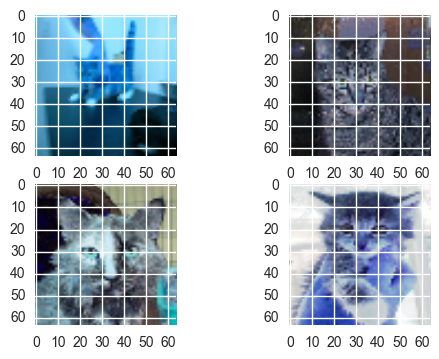

In [6]:
plt.subplot(2, 2, 1)
plt.imshow(train[0].T)
plt.subplot(2, 2, 2)
plt.imshow(train[1].T)
plt.subplot(2, 2, 3)
plt.imshow(train[2].T)
plt.subplot(2, 2, 4)
plt.imshow(train[3].T)
plt.show()

## 构建卷积网络

In [7]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

model = Sequential()
# 32个3*3的卷积核，输入图像为3*ROWS*COLS，激活函数为relu
model.add(Convolution2D(
    32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
# 池化，降采样， 就是用一个值代替一块区域，这个值可以是区域的平均值，最大值，最小值等，目的就是减少数据量
# Maxpooling取2*2矩阵中最大的值代表特征，经过降采样后，原本64*64的举证只有32*32了
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加64个3*3的卷积核
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加128个3*3的卷积核
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加256个3*3的卷积核
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten 将一个多维矩阵展开，铺平成一个一维的向量。为后面的全连接做准备。
model.add(Flatten())
# 添加第一个神经层，神经元256个
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# 添加第二个神经层，神经元256个
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# 输出神经层，一个神经元
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

In [8]:
nb_epoch = 60
batch_size = 16

hist = model.fit(train, labels, validation_split=0.25,
                 nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

Train on 18750 samples, validate on 6250 samples
Epoch 1/60
18750/18750 [==============================] - 626s - loss: 0.6302 - acc: 0.6719 - val_loss: 0.9265 - val_acc: 0.4598
Epoch 2/60
18750/18750 [==============================] - 636s - loss: 0.5287 - acc: 0.7503 - val_loss: 0.9917 - val_acc: 0.4541
Epoch 3/60
18750/18750 [==============================] - 639s - loss: 0.4845 - acc: 0.7815 - val_loss: 0.6943 - val_acc: 0.5778
Epoch 4/60
18750/18750 [==============================] - 640s - loss: 0.4628 - acc: 0.7970 - val_loss: 0.8174 - val_acc: 0.5720
Epoch 5/60
18750/18750 [==============================] - 651s - loss: 0.4408 - acc: 0.8067 - val_loss: 1.4801 - val_acc: 0.4181
Epoch 6/60
18750/18750 [==============================] - 654s - loss: 0.4400 - acc: 0.8150 - val_loss: 0.4824 - val_acc: 0.7944
Epoch 7/60
18750/18750 [==============================] - 658s - loss: 0.4309 - acc: 0.8245 - val_loss: 1.1217 - val_acc: 0.4720
Epoch 8/60
18750/18750 [========================

In [9]:
scores = model.evaluate(train, labels, verbose=1)

25000/25000 [==============================] - 286s   


In [10]:
print('Test score:', scores[0])
print('Test accuracy:', scores[1])

('Test score:', 8.059047758483894)
('Test accuracy:', 0.5)


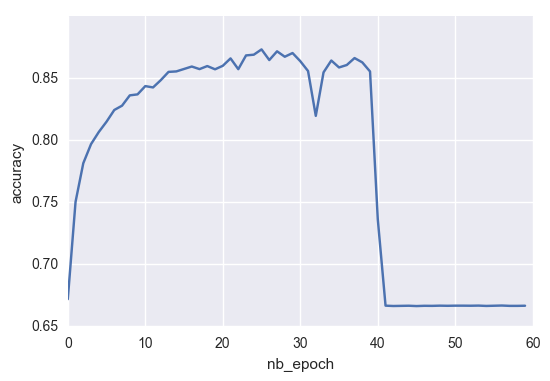

In [11]:
# 可视化一下，看看最后是否收敛
plt.plot(range(len(hist.history['acc'])), hist.history['acc'])
plt.xlabel('nb_epoch')
plt.ylabel('accuracy')
plt.show()

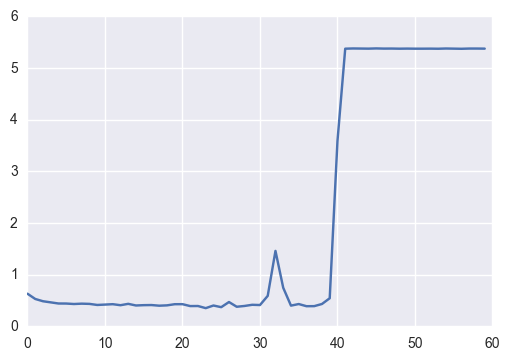

In [12]:
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.show()